# Climate Analysis Vancouver

### EDA

- Import necessary libraries for data handling and visualization.

In [2]:
# Importing all necessary libraries 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid") 

from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from prophet import Prophet

from sklearn.metrics import mean_squared_error 

from scipy import stats

from datetime import datetime

plt.rcParams["figure.figsize"] = (12, 6)  
plt.rcParams["axes.titlesize"] = 16      
plt.rcParams["axes.labelsize"] = 14       

- Load the dataset using the specified file path.
- Display the first few rows to get an overview of the dataset structure.

In [3]:
# Load the dataset
data_file_path = '/Users/shariq/Desktop/Project/data/weatherstats_vancouver_normal_monthly.csv'
data = pd.read_csv(data_file_path)

# Inspect the first few rows
data.head()

date  max_dew_point_v  max_dew_point_s  max_dew_point_c  \
0  2024-11-01             6.20             1.46             30.0   
1  2024-10-01             9.68             1.22             30.0   
2  2024-09-01            13.28             1.12             30.0   
3  2024-08-01            15.19             1.25             30.0   
4  2024-07-01            14.78             1.11             30.0   

         max_dew_point_d  max_relative_humidity_v  max_relative_humidity_s  \
0  1994-11-01 2023-11-01                    94.32                     3.60   
1  1994-10-01 2023-10-01                    94.03                     4.02   
2  1994-09-01 2023-09-01                    92.44                     3.82   
3  1994-08-01 2023-08-01                    89.05                     4.54   
4  1994-07-01 2023-07-01                    86.64                     4.48   

   max_relative_humidity_c max_relative_humidity_d  max_temperature_v  ...  \
0                     30.0   1994-11-01 2023-11-01               9.37  ...   
1                     30.0   1994-10-01 2023-10-01              13.60  ...   
2                     30.0   1994-09-01 2023-09-01              19.08  ...   
3                     30.0   1994-08-01 2023-08-01              22.57  ...   
4                     30.0   1994-07-01 2023-07-01              22.67  ...   

   snow_c                 snow_d snow_on_ground_v  snow_on_ground_s  \
0      30  1994-11-01 2023-11-01              0.3              0.72   
1      30  1994-10-01 2023-10-01              0.0              0.00   
2      30  1994-09-01 2023-09-01              0.0              0.00   
3      30  1994-08-01 2023-08-01              0.0              0.00   
4      30  1994-07-01 2023-07-01              0.0              0.00   

   snow_on_ground_c       snow_on_ground_d solar_radiation_v  \
0              24.0  1994-11-01 2022-11-01               NaN   
1              23.0  1994-10-01 2016-10-01               NaN   
2              21.0  1994-09-01 2016-09-01               NaN   
3              22.0  1994-08-01 2016-08-01               NaN   
4              23.0  1994-07-01 2017-07-01               NaN   

   solar_radiation_s  solar_radiation_c  solar_radiation_d  
0                NaN                NaN                NaN  
1                NaN                NaN                NaN  
2                NaN                NaN                NaN  
3                NaN                NaN                NaN  
4                NaN                NaN                NaN  

[5 rows x 53 columns]

**Code Explanation**:
- Convert the `date` column to datetime format for easier time-series manipulation.
- Calculate `avg_temperature_v` as the average of `max_temperature_v` and `min_temperature_v`.
- Select relevant columns (`date`, `avg_temperature_v`, `precipitation_v`), and set `date` as the index.

In [206]:
# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Add month and year for seasonal analysis
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Convert all relevant columns to numeric
for col in data.columns:
    if col.startswith(('min_', 'max_', 'temperature', 'humidity', 'precipitation', 'wind_speed')):
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Calculate averages
columns_to_drop = []
for col in data.columns:
    if col.startswith('min_') and col.replace('min_', 'max_') in data.columns:
        base_name = col.replace('min_', '')
        data[f'avg_{base_name}'] = (data[col] + data[f'max_{base_name}']) / 2
        columns_to_drop.extend([col, f'max_{base_name}'])

# Drop all columns ending with '_c', '_d'
columns_to_drop.extend([col for col in data.columns if col.endswith('_c') and col.endswith('_d')])

# Drop columns
data.drop(columns=columns_to_drop, inplace=True)

# Drop rows with missing values (temp, precip)
cleaned_data = data.dropna(subset=['avg_temperature_v', 'precipitation_v']).set_index('date')
cleaned_data['date'] = cleaned_data.index

# Drop solar radiation columns
cleaned_data = cleaned_data.drop(columns=['solar_radiation_v', 'solar_radiation_s'], errors='ignore')

# Confirm
cleaned_data.info()
cleaned_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2024-11-01 to 1941-08-01
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   precipitation_v          1000 non-null   float64       
 1   precipitation_s          1000 non-null   float64       
 2   rain_v                   1000 non-null   float64       
 3   rain_s                   1000 non-null   float64       
 4   snow_v                   1000 non-null   float64       
 5   snow_s                   1000 non-null   float64       
 6   snow_on_ground_v         827 non-null    float64       
 7   snow_on_ground_s         827 non-null    float64       
 8   month                    1000 non-null   int32         
 9   year                     1000 non-null   int32         
 10  avg_dew_point_v          851 non-null    float64       
 11  avg_dew_point_s          851 non-null    float64       
 12  avg_relative_hum

precipitation_v  precipitation_s  rain_v  rain_s  snow_v  snow_s  \
date                                                                           
2024-11-01           179.88            64.11  176.34   61.41     3.1    7.97   
2024-10-01           129.56            52.99  129.55   53.00     0.0    0.00   
2024-09-01            65.42            46.40   64.97   45.71     0.0    0.00   
2024-08-01            31.31            25.48   31.31   25.48     0.0    0.00   
2024-07-01            29.01            22.06   28.93   22.04     0.0    0.00   

            snow_on_ground_v  snow_on_ground_s  month  year  avg_dew_point_v  \
date                                                                           
2024-11-01               0.3              0.72     11  2024            4.065   
2024-10-01               0.0              0.00     10  2024            7.685   
2024-09-01               0.0              0.00      9  2024           11.380   
2024-08-01               0.0              0.00      8  2024           13.370   
2024-07-01               0.0              0.00      7  2024           12.890   

            avg_dew_point_s  avg_relative_humidity_v  avg_relative_humidity_s  \
date                                                                            
2024-11-01            1.605                   83.560                    3.740   
2024-10-01            1.310                   82.440                    3.885   
2024-09-01            1.035                   78.050                    3.675   
2024-08-01            1.205                   73.355                    4.010   
2024-07-01            1.105                   71.130                    4.195   

            avg_temperature_v  avg_temperature_s  avg_wind_speed_v  \
date                                                                 
2024-11-01              6.435              1.315            14.650   
2024-10-01             10.400              0.975            13.380   
2024-09-01             15.235              0.835            12.695   
2024-08-01             18.350              0.710            12.580   
2024-07-01             18.375              0.815            13.335   

            avg_wind_speed_s       date  
date                                     
2024-11-01             2.360 2024-11-01  
2024-10-01             1.760 2024-10-01  
2024-09-01             1.315 2024-09-01  
2024-08-01             1.260 2024-08-01  
2024-07-01             1.190 2024-07-01

**Code Explanation**:
- Plot the average temperature over time to observe general trends and seasonal fluctuations.
- Plot total monthly precipitation to identify any seasonal or long-term changes in precipitation.

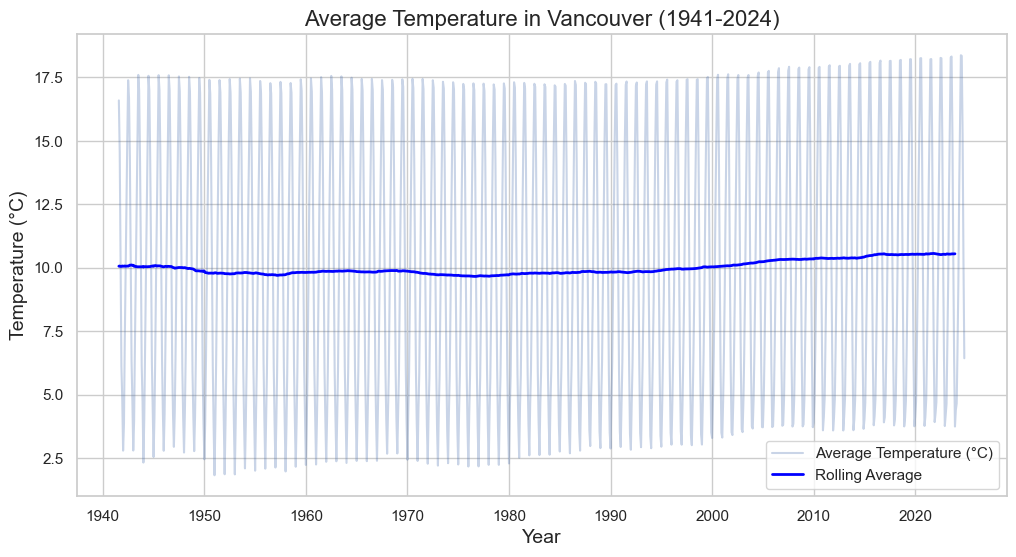

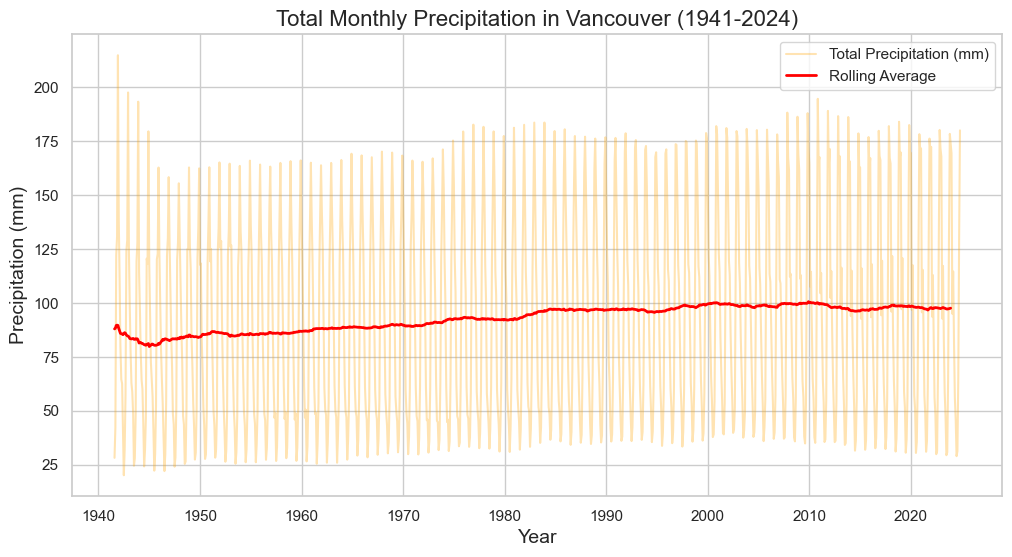

In [104]:
# Plot average temperature
plt.figure(figsize=(12, 6))
plt.plot(cleaned_data['avg_temperature_v'], label='Average Temperature (°C)', alpha=0.3)
plt.plot(cleaned_data['avg_temperature_v'].rolling(window=12).mean(), label='Rolling Average', color='blue', linewidth=2)
plt.title('Average Temperature in Vancouver (1941-2024)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plot total precipitation 
plt.figure(figsize=(12, 6))
plt.plot(cleaned_data['precipitation_v'], label='Total Precipitation (mm)', color='orange', alpha=0.3)
plt.plot(cleaned_data['precipitation_v'].rolling(window=12).mean(), label='Rolling Average', color='red', linewidth=2)
plt.title('Total Monthly Precipitation in Vancouver (1941-2024)')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

#### Seasonal Decomposition (Temp)

1.	Top Panel (Observed):
- Shows the original data series (avg_temperature_v in this case). It’s the observed average temperature over time.

2.	Second Panel (Trend):
- Represents the long-term trend in the data. This isolates the general increase/decrease in temperatures over time, removing short-term variations.

3.	Third Panel (Seasonal):
- Shows recurring patterns (seasonality). For temperature, this typically reflects the annual cycle (e.g., warmer in summer, colder in winter).

4.	Bottom Panel (Residual):
- The residuals are the remaining variations after removing the trend and seasonal components. These represent noise or unexplained variability.

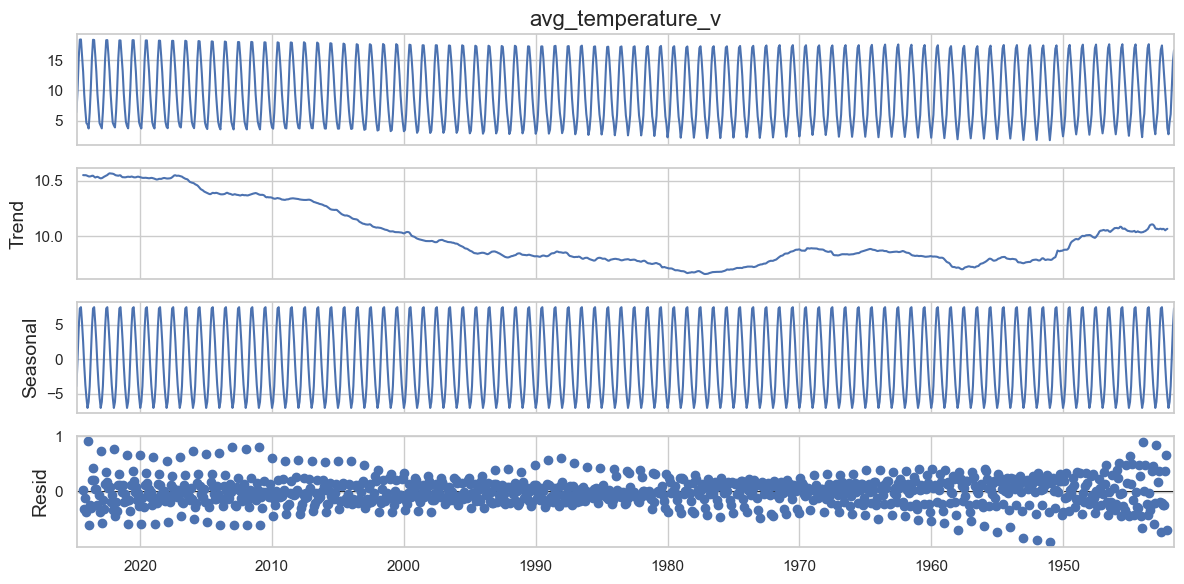

In [105]:
# Temperature seasonal decomposition

# Plot residuals with reference lines
temp_decomposition = seasonal_decompose(cleaned_data.set_index('date')['avg_temperature_v'], model='additive', period=12)
temp_decomposition.plot()
plt.show()

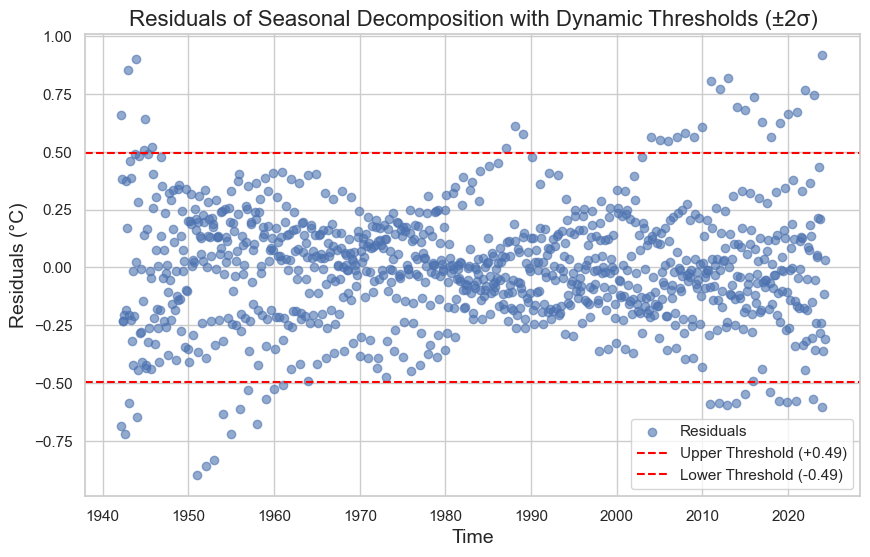

Standard Deviation of Residuals: 0.25
Upper Threshold (+2σ): 0.49
Lower Threshold (-2σ): -0.49


In [106]:
residual_std = np.std(decompose_result.resid.dropna())

# Define thresholds as ±2 standard deviations
upper_threshold = 2 * residual_std
lower_threshold = -2 * residual_std

# Plot residuals 
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data.index, decompose_result.resid, alpha=0.6, label='Residuals')
plt.axhline(y=upper_threshold, color='red', linestyle='--', label=f'Upper Threshold (+{upper_threshold:.2f})')
plt.axhline(y=lower_threshold, color='red', linestyle='--', label=f'Lower Threshold ({lower_threshold:.2f})')
plt.title('Residuals of Seasonal Decomposition with Dynamic Thresholds (±2σ)')
plt.xlabel('Time')
plt.ylabel('Residuals (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Output the thresholds
print(f"Standard Deviation of Residuals: {residual_std:.2f}")
print(f"Upper Threshold (+2σ): {upper_threshold:.2f}")
print(f"Lower Threshold (-2σ): {lower_threshold:.2f}")

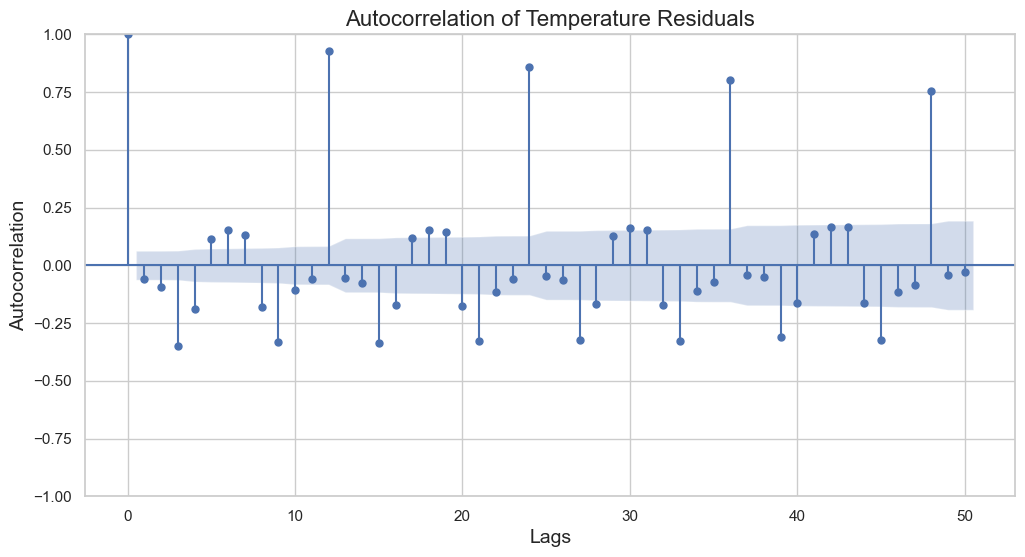

In [107]:
# Autocorrelation of residuals
plot_acf(decompose_result.resid.dropna(), lags=50)
plt.title('Autocorrelation of Temperature Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

1.	Purpose:
- This code generates a temperature forecast using the Prophet model.
- It includes yearly and multi-year seasonality (capturing both 12-month cycles and longer-term patterns).
2.	Key Outputs:
- A plot that visualizes the historical temperature data (black dots), model predictions (blue line), and forecast uncertainty intervals (shaded regions).

22:14:53 - cmdstanpy - INFO - Chain [1] start processing
22:14:53 - cmdstanpy - INFO - Chain [1] done processing
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.h

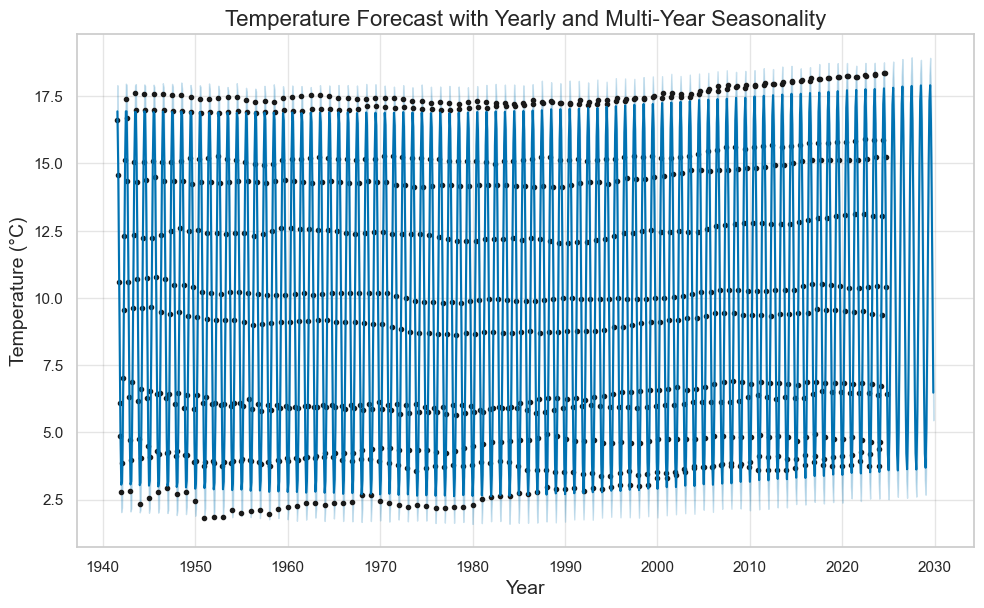

In [108]:
temperature_model = Prophet(yearly_seasonality=False)
temperature_model.add_seasonality(name='yearly', period=12, fourier_order=3)
temperature_model.add_seasonality(name='multi-year', period=365*2, fourier_order=2)  # Multi-year pattern

# Fit the model
temperature_model.fit(cleaned_data[['avg_temperature_v']].reset_index().rename(columns={'date': 'ds', 'avg_temperature_v': 'y'}))

# Create future dates and forecast
future_temp = temperature_model.make_future_dataframe(periods=60, freq='M')
forecast_temp = temperature_model.predict(future_temp)

# Plot the forecast with labeled axes and a title
fig = temperature_model.plot(forecast_temp, figsize=(10, 6))
plt.title("Temperature Forecast with Yearly and Multi-Year Seasonality", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.grid(True)
plt.show()

1.	Residual Calculation:
- Subtracts the predicted values (yhat) from the actual observed values (avg_temperature_v).
2.	Scatter Plot:
- Shows how the residuals are distributed over time.
- A horizontal zero line is added to highlight deviations.


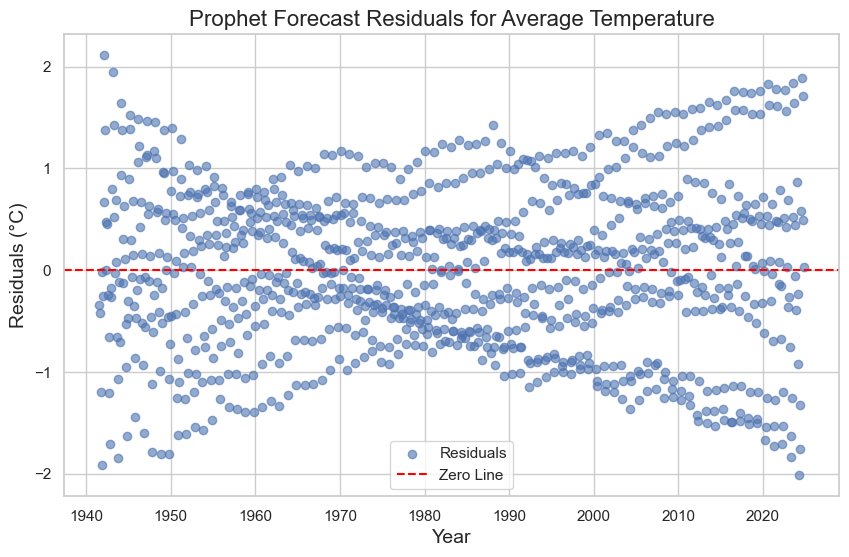

In [109]:
# Ensure indices are aligned for residual calculation
aligned_forecast = forecast_temp.set_index('ds').reindex(cleaned_data.index)

# Calculate residuals: Observed - Predicted
aligned_forecast['residuals'] = cleaned_data['avg_temperature_v'] - aligned_forecast['yhat']

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data.index, aligned_forecast['residuals'], alpha=0.6, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Zero Line')
plt.title('Prophet Forecast Residuals for Average Temperature')
plt.xlabel('Year')
plt.ylabel('Residuals (°C)')
plt.grid(True)
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

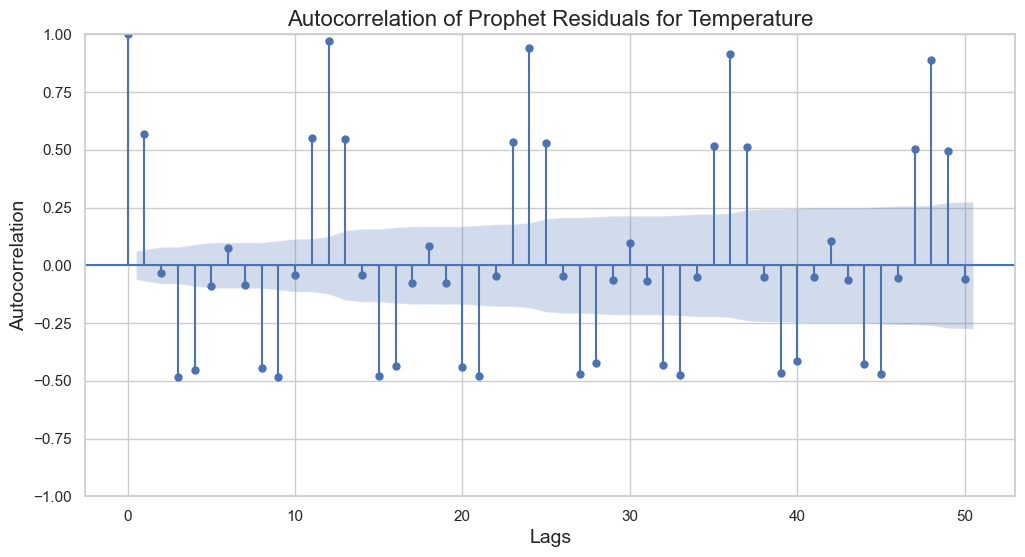

In [100]:
# Plot autocorrelation of residuals
plt.figure(figsize=(10, 6))
plot_acf(aligned_forecast['residuals'].dropna(), lags=50, alpha=0.05)
plt.title('Autocorrelation of Prophet Residuals for Temperature')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

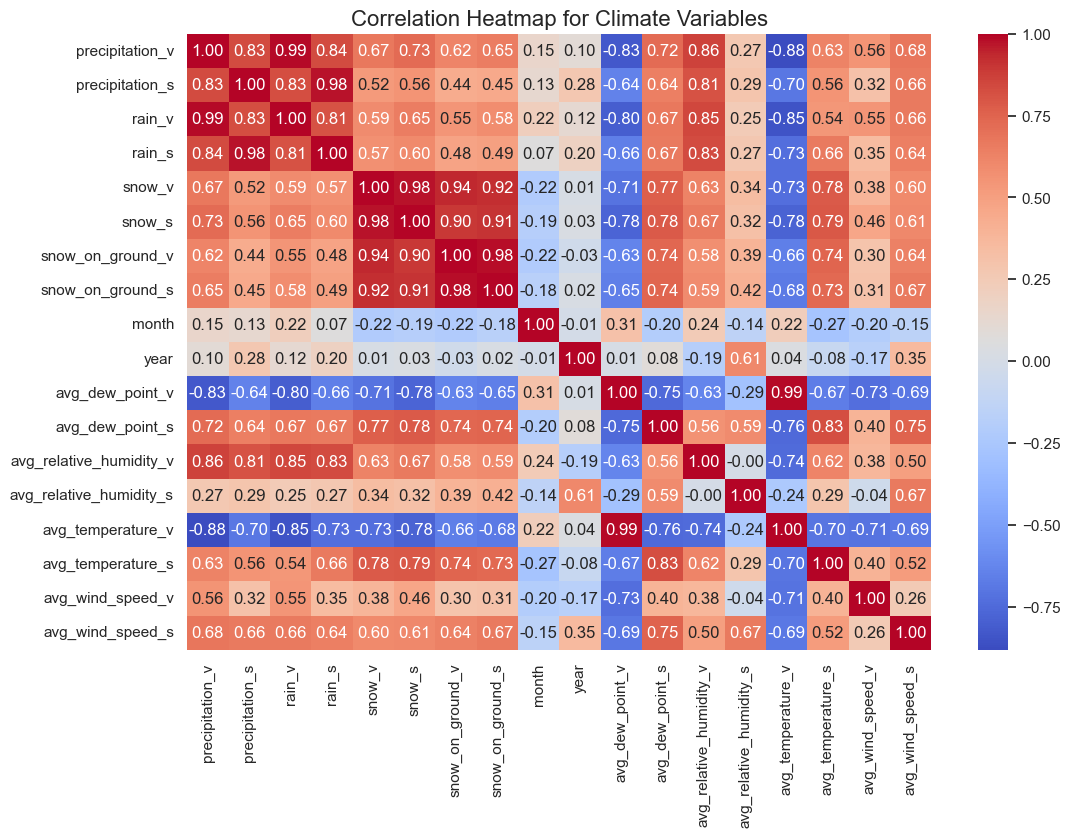

In [284]:
# Compute the correlation matrix
correlation_matrix = cleaned_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Heatmap for Climate Variables')
plt.show()

Missing values in key regressors (e.g., avg_dew_point_v, precipitation_v, rain_v, and avg_relative_humidity_v) are filled with their respective column means to ensure a complete dataset for Prophet modeling.

In [160]:
cleaned_data_2 = cleaned_data.copy()

# Handle missing values by filling with mean
for col in ['avg_dew_point_v', 'precipitation_v', 'rain_v', 'avg_relative_humidity_v']:
    cleaned_data_2[col] = cleaned_data_2[col].fillna(cleaned_data_2[col].mean())

Explanation:
Prepare the dataset in the format required by Prophet (ds for date and y for the target variable). Include selected regressors to enhance the model’s predictive power.

In [244]:
# Ensure no duplicate 'ds' or 'date' columns
if 'ds' in cleaned_data_2.columns:
    cleaned_data_2 = cleaned_data_2.drop(columns=['ds'])
if 'date' in cleaned_data_2.columns:
    cleaned_data_2 = cleaned_data_2.drop(columns=['date'])

# Prepare data for Prophet
prophet_data = cleaned_data_2.reset_index().rename(columns={'date': 'ds', 'avg_temperature_v': 'y'})

# Selected regressors to include in Prophet
regressors = ['avg_dew_point_v', 'precipitation_v']

# Ensure no duplicates exist in 'ds' and 'regressors' in prophet_data
for col in regressors:
    if col not in prophet_data.columns:
        print(f"Missing column in cleaned data: {col}")

# Output the first few rows to confirm structure
prophet_data.head()

ds  precipitation_v  precipitation_s  rain_v  rain_s  snow_v  \
0 2024-11-01           179.88            64.11  176.34   61.41     3.1   
1 2024-10-01           129.56            52.99  129.55   53.00     0.0   
2 2024-09-01            65.42            46.40   64.97   45.71     0.0   
3 2024-08-01            31.31            25.48   31.31   25.48     0.0   
4 2024-07-01            29.01            22.06   28.93   22.04     0.0   

   snow_s  snow_on_ground_v  snow_on_ground_s  month  year  avg_dew_point_v  \
0    7.97               0.3              0.72     11  2024            4.065   
1    0.00               0.0              0.00     10  2024            7.685   
2    0.00               0.0              0.00      9  2024           11.380   
3    0.00               0.0              0.00      8  2024           13.370   
4    0.00               0.0              0.00      7  2024           12.890   

   avg_dew_point_s  avg_relative_humidity_v  avg_relative_humidity_s       y  \
0            1.605                   83.560                    3.740   6.435   
1            1.310                   82.440                    3.885  10.400   
2            1.035                   78.050                    3.675  15.235   
3            1.205                   73.355                    4.010  18.350   
4            1.105                   71.130                    4.195  18.375   

   avg_temperature_s  avg_wind_speed_v  avg_wind_speed_s  
0              1.315            14.650             2.360  
1              0.975            13.380             1.760  
2              0.835            12.695             1.315  
3              0.710            12.580             1.260  
4              0.815            13.335             1.190

23:10:43 - cmdstanpy - INFO - Chain [1] start processing
23:10:44 - cmdstanpy - INFO - Chain [1] done processing
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.h

<Figure size 1000x600 with 0 Axes>

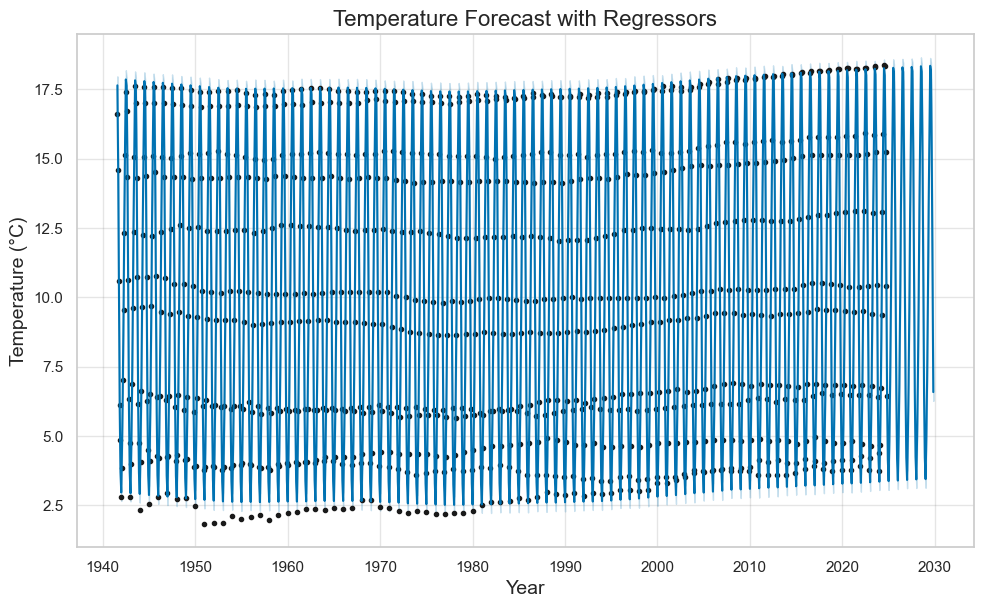

ds       yhat  yhat_lower  yhat_upper
1055 2029-06-30  18.342439   18.024032   18.625473
1056 2029-07-31  18.161108   17.865658   18.473729
1057 2029-08-31  15.264734   14.949753   15.554217
1058 2029-09-30  10.775140   10.451529   11.101418
1059 2029-10-31   6.577800    6.262101    6.877681

In [245]:
# Step 1: Initialize the Prophet model
temperature_model = Prophet(yearly_seasonality=True)

# Step 2: Add regressors to the model
for regressor in regressors:
    temperature_model.add_regressor(regressor)

# Step 3: Fit the model
temperature_model.fit(prophet_data)

# Step 4: Generate future dates and extend regressors
future_data = temperature_model.make_future_dataframe(periods=60, freq='M')
for regressor in regressors:
    future_data[regressor] = cleaned_data_2[regressor].mean()  # Propagate the mean for simplicity

# Step 5: Make predictions
forecast_temp_with_regressors = temperature_model.predict(future_data)

# Step 6: Plot the forecast
plt.figure(figsize=(10, 6))
temperature_model.plot(forecast_temp_with_regressors)
plt.title('Temperature Forecast with Regressors')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Step 7: Display forecast results
forecast_temp_with_regressors[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

This step computes the residuals (difference between actual and predicted values) for both models and evaluates their performance using RMSE and MAPE.

In [246]:
# Calculate residuals for the model with regressors
aligned_forecast_regressors = forecast_temp_with_regressors.set_index('ds').reindex(cleaned_data_2.index)
aligned_forecast_regressors['residuals'] = cleaned_data_2['avg_temperature_v'] - aligned_forecast_regressors['yhat']

# Calculate residuals for the baseline model
aligned_forecast_baseline = forecast_temp.set_index('ds').reindex(cleaned_data_2.index)
aligned_forecast_baseline['residuals'] = cleaned_data_2['avg_temperature_v'] - aligned_forecast_baseline['yhat']

# Compute RMSE for both models
rmse_regressors = np.sqrt(mean_squared_error(cleaned_data_2['avg_temperature_v'], aligned_forecast_regressors['yhat']))
rmse_baseline = np.sqrt(mean_squared_error(cleaned_data_2['avg_temperature_v'], aligned_forecast_baseline['yhat']))

# Compute MAPE for both models
mape_regressors = mean_absolute_percentage_error(cleaned_data_2['avg_temperature_v'], aligned_forecast_regressors['yhat'])
mape_baseline = mean_absolute_percentage_error(cleaned_data_2['avg_temperature_v'], aligned_forecast_baseline['yhat'])

# Display performance metrics
print("Performance Comparison:")
print(f"Baseline Model RMSE: {rmse_baseline:.2f}, MAPE: {mape_baseline:.2%}")
print(f"Model with Regressors RMSE: {rmse_regressors:.2f}, MAPE: {mape_regressors:.2%}")

Performance Comparison:
Baseline Model RMSE: 0.42, MAPE: 6.19%
Model with Regressors RMSE: 0.30, MAPE: 4.03%


	Trend: The long-term directional movement in temperature.
	•	Seasonality: Recurring patterns within the data, such as yearly fluctuations.
	•	Regressors: The contribution of avg_dew_point_v and precipitation_v to the forecast.

/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To ret

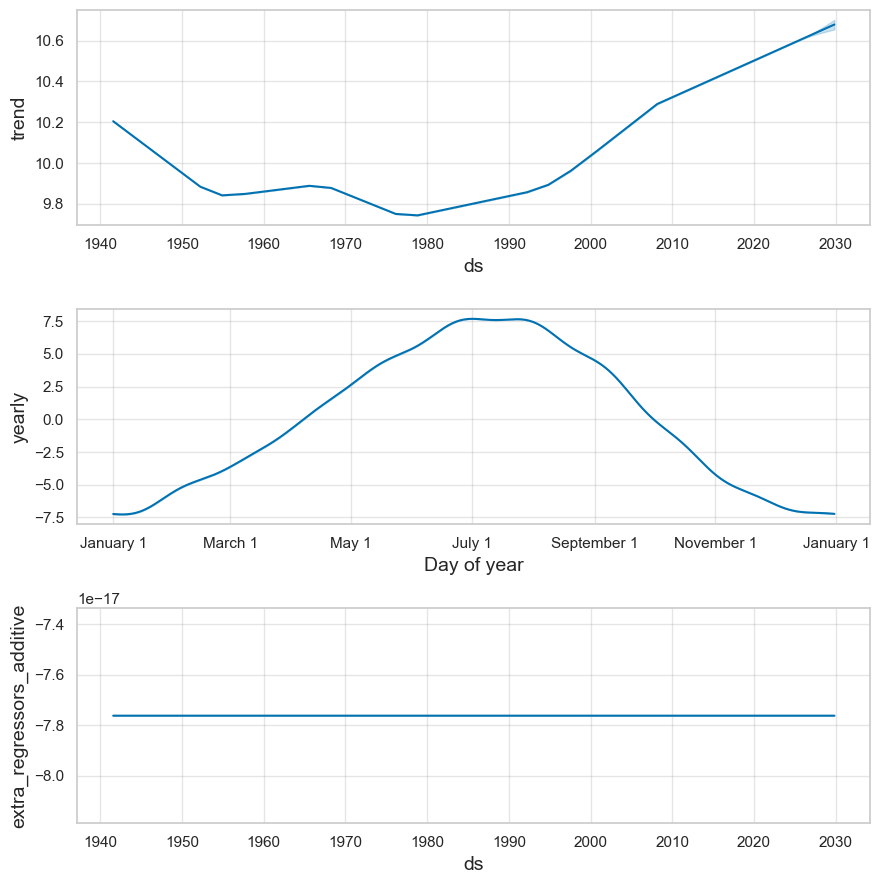

In [247]:
# Step 1: Plot forecast components
# Analyze trend, seasonality, and regressor contributions
temperature_model.plot_components(forecast_temp_with_regressors)
plt.show()

	1.	Trend Component:
	•	The top plot indicates a long-term upward trend in average temperature, particularly noticeable post-1980. This trend aligns with global warming observations and suggests sustained temperature increases into the future.
	2.	Yearly Seasonality:
	•	The middle plot reveals strong seasonal patterns, with temperatures peaking around July (summer) and dropping sharply around January (winter). The cyclical nature reflects expected seasonal changes.
	3.	Extra Regressors (Additive):
	•	The bottom plot, representing the contribution of additional regressors (avg_dew_point_v, precipitation_v), shows negligible variation. This could mean the regressors are not significantly impacting the forecast model. Adjustments may be needed to refine their influence.

In [253]:
forecast_summary = forecast_temp_with_regressors[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print("Final Forecast Summary:")
print(forecast_summary.tail())

Final Forecast Summary:
             ds       yhat  yhat_lower  yhat_upper
1055 2029-06-30  18.342439   18.024032   18.625473
1056 2029-07-31  18.161108   17.865658   18.473729
1057 2029-08-31  15.264734   14.949753   15.554217
1058 2029-09-30  10.775140   10.451529   11.101418
1059 2029-10-31   6.577800    6.262101    6.877681


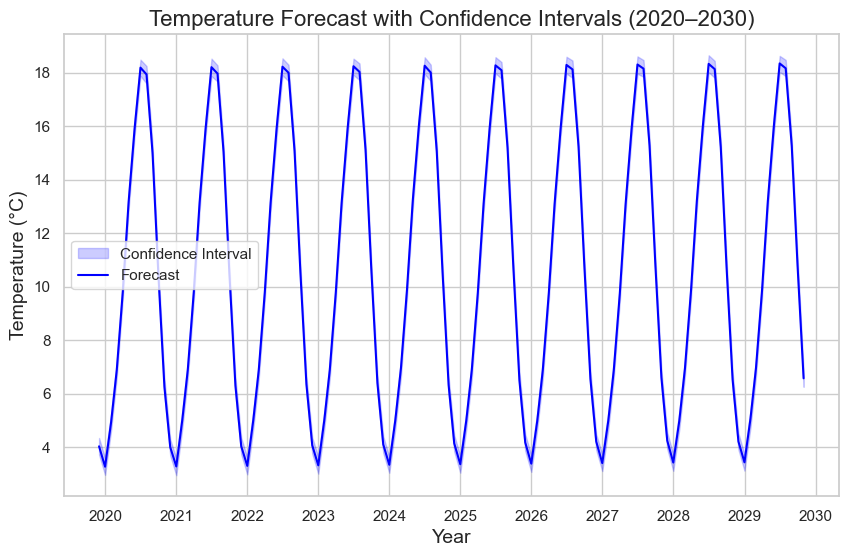

In [254]:
plt.figure(figsize=(10, 6))
plt.fill_between(
    forecast_summary['ds'][-120:], 
    forecast_summary['yhat_lower'][-120:], 
    forecast_summary['yhat_upper'][-120:], 
    color='blue', alpha=0.2, label='Confidence Interval'
)
plt.plot(forecast_summary['ds'][-120:], forecast_summary['yhat'][-120:], label='Forecast', color='blue')
plt.title('Temperature Forecast with Confidence Intervals (2020–2030)')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [255]:
trend_diff = forecast_temp_with_regressors['trend'].iloc[-1] - forecast_temp_with_regressors['trend'].iloc[0]
years_span = (forecast_temp_with_regressors['ds'].iloc[-1] - forecast_temp_with_regressors['ds'].iloc[0]).days / 365.25
trend_rate = trend_diff / years_span
print(f"Average Rate of Temperature Increase: {trend_rate:.2f} °C per year")

Average Rate of Temperature Increase: 0.01 °C per year


/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1000x600 with 0 Axes>

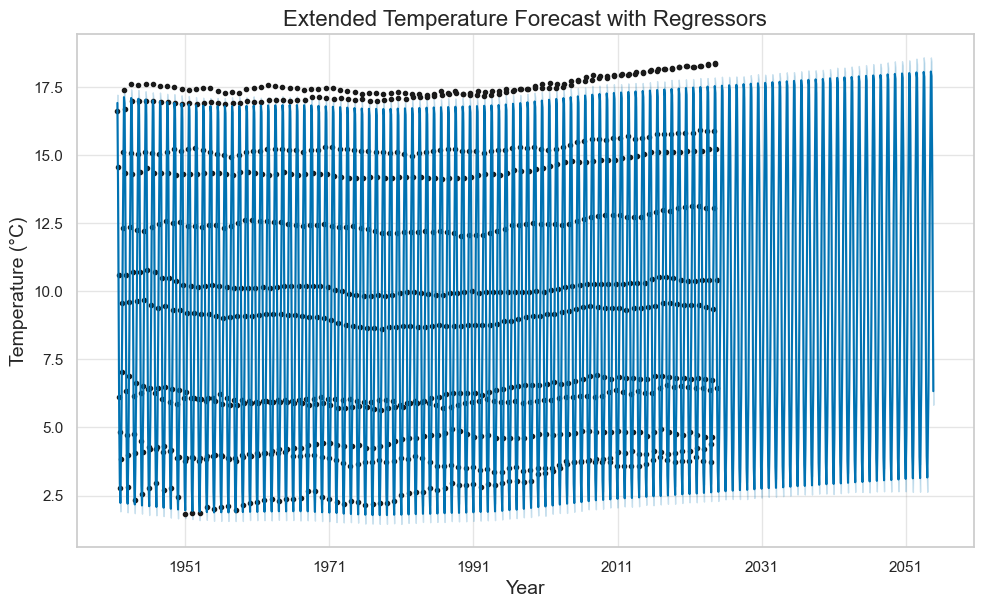

ds       yhat  yhat_lower  yhat_upper
1355 2054-06-30  18.060136   17.533668   18.577303
1356 2054-07-31  17.892742   17.391333   18.424559
1357 2054-08-31  15.005116   14.528832   15.533060
1358 2054-09-30  10.529540    9.977553   11.050864
1359 2054-10-31   6.329979    5.833009    6.861505

In [263]:
# Generate future dates for extended forecasting
extended_future_data = temperature_model.make_future_dataframe(periods=360, freq='M')  # Extend to 30 years
for regressor in regressors:
    extended_future_data[regressor] = cleaned_data_2[regressor].mean()  # Use mean for simplicity

# Generate extended forecast
extended_forecast = temperature_model.predict(extended_future_data)

# Plot extended forecast
plt.figure(figsize=(10, 6))
temperature_model.plot(extended_forecast)
plt.title('Extended Temperature Forecast with Regressors')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Display last few rows of forecast
extended_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [283]:
# Drop rows with invalid dates
cleaned_data = cleaned_data[pd.to_datetime(cleaned_data.index, errors='coerce').notna()]

# Step 1: Reset index to ensure 'date' is a column
if cleaned_data.index.name == 'date':
    cleaned_data = cleaned_data.reset_index()

# Step 2: Prepare data for Prophet (rename columns for Prophet)
prophet_data_no_regressors = cleaned_data.rename(columns={'date': 'ds', 'avg_temperature_v': 'y'})

# Debug: Confirm the structure
print(prophet_data_no_regressors.columns)
print(prophet_data_no_regressors.head())

# Step 1: Drop duplicate 'date' column if it exists
if 'date' in cleaned_data.columns:
    cleaned_data = cleaned_data.drop(columns=['date'])

# Step 2: Prepare data for Prophet
prophet_data_no_regressors = cleaned_data.reset_index().rename(columns={'index': 'ds', 'avg_temperature_v': 'y'})

# Step 3: Initialize the Prophet model without regressors
temperature_model_no_regressors = Prophet(yearly_seasonality=True)

# Step 4: Fit the model with only the temperature data
temperature_model_no_regressors.fit(prophet_data_no_regressors)

# Step 5: Generate future dates for the forecast
future_data_no_regressors = temperature_model_no_regressors.make_future_dataframe(periods=60, freq='M')

# Step 6: Make predictions
forecast_temp_no_regressors = temperature_model_no_regressors.predict(future_data_no_regressors)

# Step 7: Plot the forecast
plt.figure(figsize=(10, 6))
temperature_model_no_regressors.plot(forecast_temp_no_regressors)
plt.title('Temperature Forecast Without Regressors')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Step 8: Display forecast results (optional)
forecast_temp_no_regressors[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['precipitation_v', 'precipitation_s', 'rain_v', 'rain_s', 'snow_v',
       'snow_s', 'snow_on_ground_v', 'snow_on_ground_s', 'month', 'year',
       'avg_dew_point_v', 'avg_dew_point_s', 'avg_relative_humidity_v',
       'avg_relative_humidity_s', 'y', 'avg_temperature_s', 'avg_wind_speed_v',
       'avg_wind_speed_s'],
      dtype='object')
   precipitation_v  precipitation_s  rain_v  rain_s  snow_v  snow_s  \
0           179.88            64.11  176.34   61.41     3.1    7.97   
1           129.56            52.99  129.55   53.00     0.0    0.00   
2            65.42            46.40   64.97   45.71     0.0    0.00   
3            31.31            25.48   31.31   25.48     0.0    0.00   
4            29.01            22.06   28.93   22.04     0.0    0.00   

   snow_on_ground_v  snow_on_ground_s  month  year  avg_dew_point_v  \
0               0.3              0.72     11  2024            4.065   
1               0.0              0.00     10  2024            7.685   
2        

/Users/shariq/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:287: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])


DateParseError: day is out of range for month: 0, at position 0

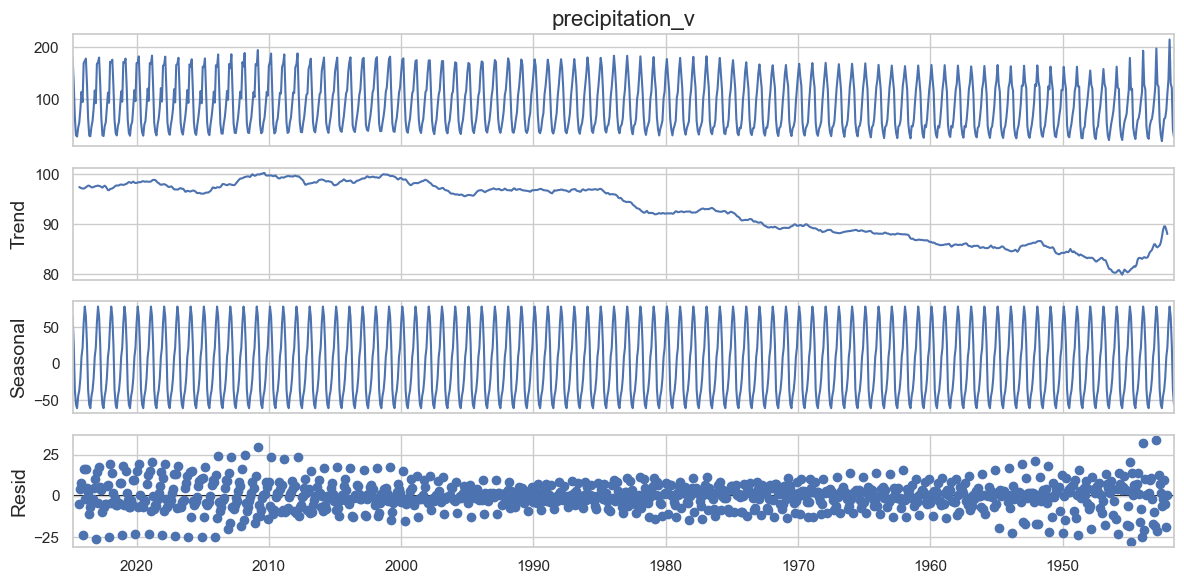

In [207]:
# Precipitation seasonal decomposition
temp_decomposition = seasonal_decompose(cleaned_data.set_index('date')['precipitation_v'], model='additive', period=12)
temp_decomposition.plot()
plt.show()

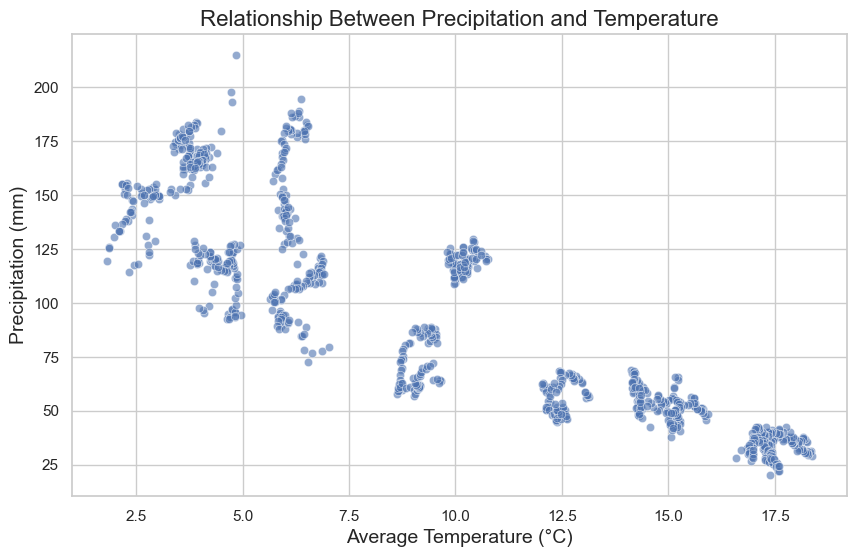

Correlation Coefficient: -0.88


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for precipitation vs. temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cleaned_data['avg_temperature_v'], y=cleaned_data['precipitation_v'], alpha=0.6)
plt.title('Relationship Between Precipitation and Temperature')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

# Calculate and display the correlation coefficient
correlation = cleaned_data['precipitation_v'].corr(cleaned_data['avg_temperature_v'])
print(f"Correlation Coefficient: {correlation:.2f}")

/var/folders/vq/thgcfn217yd6x8lc8f1px5r80000gn/T/ipykernel_1474/3464424578.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = cleaned_data.resample('Y').agg({


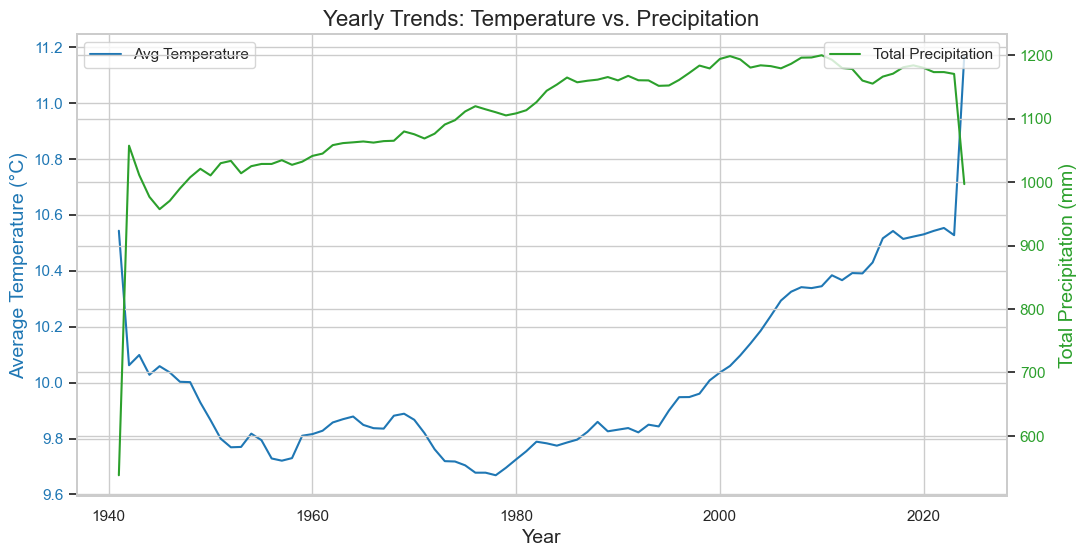

Correlation between yearly average temperature and total precipitation: 0.12


In [53]:
import matplotlib.pyplot as plt

# Group data by year to compute annual averages
yearly_data = cleaned_data.resample('Y').agg({
    'avg_temperature_v': 'mean',  # Average yearly temperature
    'precipitation_v': 'sum'     # Total yearly precipitation
}).reset_index()

# Convert 'date' column to year only for clarity in plots
yearly_data['year'] = yearly_data['date'].dt.year

# Plot temperature and precipitation trends over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average temperature
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Temperature (°C)', color='tab:blue')
ax1.plot(yearly_data['year'], yearly_data['avg_temperature_v'], color='tab:blue', label='Avg Temperature')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Plot total precipitation on the same graph
ax2 = ax1.twinx()  # Create a twin y-axis
ax2.set_ylabel('Total Precipitation (mm)', color='tab:green')
ax2.plot(yearly_data['year'], yearly_data['precipitation_v'], color='tab:green', label='Total Precipitation')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

# Add a title
plt.title('Yearly Trends: Temperature vs. Precipitation')
plt.show()

# Calculate correlation between yearly average temperature and total precipitation
correlation = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_v'])
print(f"Correlation between yearly average temperature and total precipitation: {correlation:.2f}")

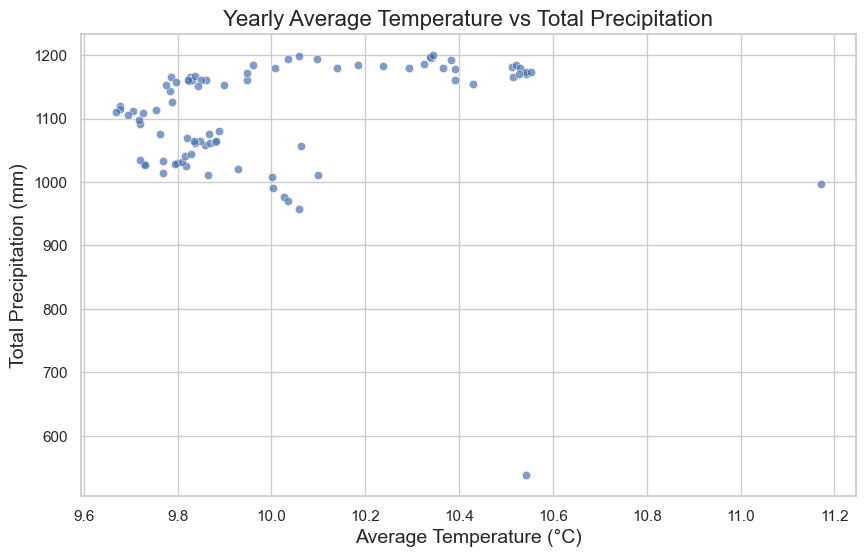

Correlation Coefficient (Yearly Avg Temp vs Total Precip): 0.12


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for yearly average temperature vs total precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=yearly_data['avg_temperature_v'], y=yearly_data['precipitation_v'], alpha=0.7)
plt.title('Yearly Average Temperature vs Total Precipitation')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Precipitation (mm)')
plt.grid(True)
plt.show()

# Calculate correlation coefficient between yearly average temperature and total precipitation
yearly_correlation = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_v'])
print(f"Correlation Coefficient (Yearly Avg Temp vs Total Precip): {yearly_correlation:.2f}")

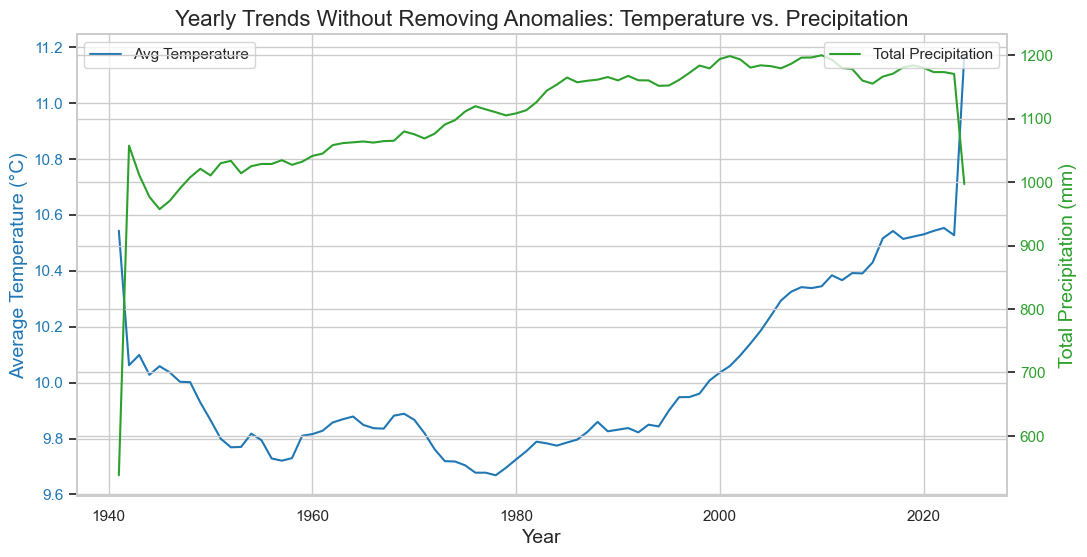

Correlation after improved handling: 0.12


In [56]:
# Step 1: Retain all anomalies and plot trends
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average temperature
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Temperature (°C)', color='tab:blue')
ax1.plot(yearly_data['year'], yearly_data['avg_temperature_v'], color='tab:blue', label='Avg Temperature')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Plot total precipitation on the same graph
ax2 = ax1.twinx()  # Create a twin y-axis
ax2.set_ylabel('Total Precipitation (mm)', color='tab:green')
ax2.plot(yearly_data['year'], yearly_data['precipitation_v'], color='tab:green', label='Total Precipitation')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title('Yearly Trends Without Removing Anomalies: Temperature vs. Precipitation')
plt.show()
yearly_correlation_cleaned = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_v'])
print(f"Correlation after improved handling: {yearly_correlation_cleaned:.2f}")

Year with max precipitation: 2010
Year with min precipitation: 1941
Year with max temperature: 2024
Year with min temperature: 1978
         date  avg_temperature_v  precipitation_v  year
0  1941-12-31          10.543000           537.96  1941
37 1978-12-31           9.668750          1110.05  1978
69 2010-12-31          10.344583          1199.84  2010
83 2024-12-31          11.170455           996.76  2024


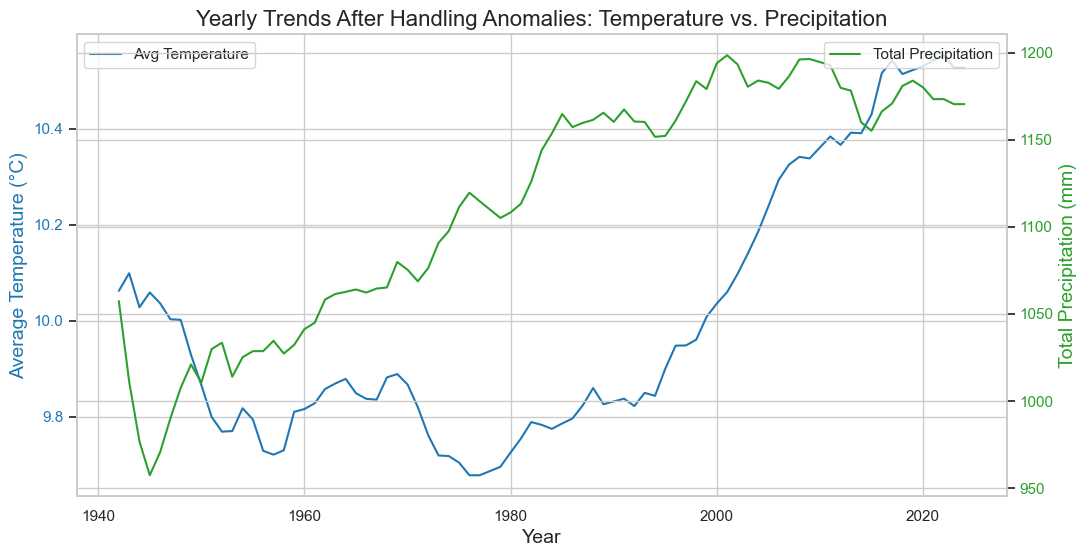

Correlation between yearly average temperature and total precipitation (after cleaning): 0.50


In [58]:
# Step 1: Identify the anomaly
# Find the year(s) with the maximum and minimum precipitation and temperature
max_precip_year = yearly_data.loc[yearly_data['precipitation_v'].idxmax(), 'year']
min_precip_year = yearly_data.loc[yearly_data['precipitation_v'].idxmin(), 'year']
max_temp_year = yearly_data.loc[yearly_data['avg_temperature_v'].idxmax(), 'year']
min_temp_year = yearly_data.loc[yearly_data['avg_temperature_v'].idxmin(), 'year']

print(f"Year with max precipitation: {max_precip_year}")
print(f"Year with min precipitation: {min_precip_year}")
print(f"Year with max temperature: {max_temp_year}")
print(f"Year with min temperature: {min_temp_year}")

# Step 2: Inspect these years for anomalies
print(yearly_data.loc[
    (yearly_data['year'] == max_precip_year) | 
    (yearly_data['year'] == min_precip_year) |
    (yearly_data['year'] == max_temp_year) | 
    (yearly_data['year'] == min_temp_year)
])

# Step 3: Handle anomalies
# If anomalies are confirmed (e.g., large spikes or dips), use interpolation to correct:
anomaly_years = [max_precip_year, min_precip_year, max_temp_year, min_temp_year]

# Interpolate or remove rows with anomalies
# Interpolating based on neighboring years
for col in ['precipitation_v', 'avg_temperature_v']:
    yearly_data.loc[yearly_data['year'].isin(anomaly_years), col] = None

# Perform linear interpolation for the missing values
yearly_data.interpolate(method='linear', inplace=True)

# Step 4: Re-plot the yearly trends after handling anomalies
# Dual Y-Axis Plot for yearly temperature and precipitation
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average temperature
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Temperature (°C)', color='tab:blue')
ax1.plot(yearly_data['year'], yearly_data['avg_temperature_v'], color='tab:blue', label='Avg Temperature')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Plot total precipitation on the same graph
ax2 = ax1.twinx()  # Create a twin y-axis
ax2.set_ylabel('Total Precipitation (mm)', color='tab:green')
ax2.plot(yearly_data['year'], yearly_data['precipitation_v'], color='tab:green', label='Total Precipitation')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

# Add a title
plt.title('Yearly Trends After Handling Anomalies: Temperature vs. Precipitation')
plt.show()

# Step 5: Re-check correlation after handling anomalies
yearly_correlation_cleaned = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_v'])
print(f"Correlation between yearly average temperature and total precipitation (after cleaning): {yearly_correlation_cleaned:.2f}")

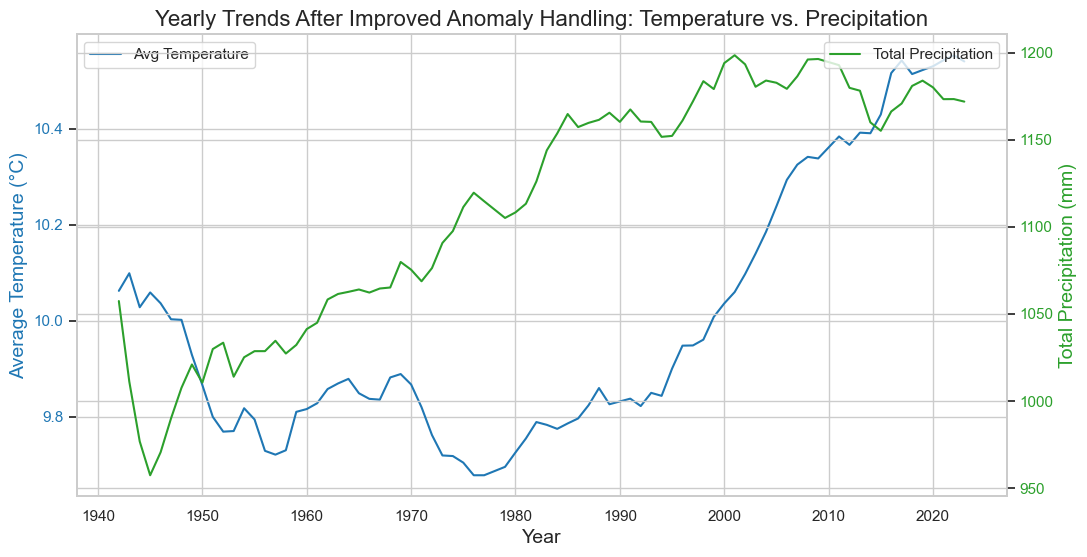

Correlation after improved handling: 0.49


In [66]:
# Step 1: Identify anomaly years
anomaly_years = [1941, 1978]  # Focus on mid-range years, avoid terminal years like 2024

# Step 2: Remove anomalies from mid-range years and interpolate
for col in ['precipitation_v', 'avg_temperature_v']:
    yearly_data.loc[yearly_data['year'].isin(anomaly_years), col] = None

# Perform linear interpolation only for mid-range years
yearly_data.interpolate(method='linear', inplace=True)

# Step 3: Exclude terminal years (e.g., 2024) from analysis if necessary
yearly_data = yearly_data[yearly_data['year'] < 2024]

# Step 4: Re-plot the trends and recompute correlations
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average temperature
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Temperature (°C)', color='tab:blue')
ax1.plot(yearly_data['year'], yearly_data['avg_temperature_v'], color='tab:blue', label='Avg Temperature')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Plot total precipitation on the same graph
ax2 = ax1.twinx()  # Create a twin y-axis
ax2.set_ylabel('Total Precipitation (mm)', color='tab:green')
ax2.plot(yearly_data['year'], yearly_data['precipitation_v'], color='tab:green', label='Total Precipitation')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title('Yearly Trends After Improved Anomaly Handling: Temperature vs. Precipitation')
plt.show()

# Recompute correlation
yearly_correlation_cleaned = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_v'])
print(f"Correlation after improved handling: {yearly_correlation_cleaned:.2f}")

In [64]:
# # Step 1: Retain all anomalies and plot trends
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot average temperature
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Average Temperature (°C)', color='tab:blue')
# ax1.plot(yearly_data['year'], yearly_data['avg_temperature_v'], color='tab:blue', label='Avg Temperature')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
# ax1.legend(loc='upper left')

# # Plot total precipitation on the same graph
# ax2 = ax1.twinx()  # Create a twin y-axis
# ax2.set_ylabel('Total Precipitation (mm)', color='tab:green')
# ax2.plot(yearly_data['year'], yearly_data['precipitation_v'], color='tab:green', label='Total Precipitation')
# ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.legend(loc='upper right')

# plt.title('Yearly Trends Without Removing Anomalies: Temperature vs. Precipitation')
# plt.show()

# # Step 2: Compute correlation without removing anomalies
# correlation_with_anomalies = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_v'])
# print(f"Correlation without removing anomalies: {correlation_with_anomalies:.2f}")

In [65]:
# # Exclude 2024 and plot trends
# yearly_data_without_2024 = yearly_data[yearly_data['year'] < 2024]

# # Plot without 2024
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot average temperature
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Average Temperature (°C)', color='tab:blue')
# ax1.plot(yearly_data_without_2024['year'], yearly_data_without_2024['avg_temperature_v'], color='tab:blue', label='Avg Temperature')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
# ax1.legend(loc='upper left')

# # Plot total precipitation on the same graph
# ax2 = ax1.twinx()  # Create a twin y-axis
# ax2.set_ylabel('Total Precipitation (mm)', color='tab:green')
# ax2.plot(yearly_data_without_2024['year'], yearly_data_without_2024['precipitation_v'], color='tab:green', label='Total Precipitation')
# ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.legend(loc='upper right')

# plt.title('Yearly Trends Excluding 2024: Temperature vs. Precipitation')
# plt.show()

# # Recompute correlation excluding 2024
# correlation_without_2024 = yearly_data_without_2024['avg_temperature_v'].corr(yearly_data_without_2024['precipitation_v'])
# print(f"Correlation excluding 2024: {correlation_without_2024:.2f}")

# # Plot including 2024
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot average temperature
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Average Temperature (°C)', color='tab:blue')
# ax1.plot(yearly_data['year'], yearly_data['avg_temperature_v'], color='tab:blue', label='Avg Temperature')
# ax1.tick_params(axis='y', labelcolor='tab:blue')
# ax1.legend(loc='upper left')

# # Plot total precipitation on the same graph
# ax2 = ax1.twinx()  # Create a twin y-axis
# ax2.set_ylabel('Total Precipitation (mm)', color='tab:green')
# ax2.plot(yearly_data['year'], yearly_data['precipitation_v'], color='tab:green', label='Total Precipitation')
# ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.legend(loc='upper right')

# plt.title('Yearly Trends Including 2024: Temperature vs. Precipitation')
# plt.show()

# # Recompute correlation including 2024
# correlation_with_2024 = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_v'])
# print(f"Correlation including 2024: {correlation_with_2024:.2f}")

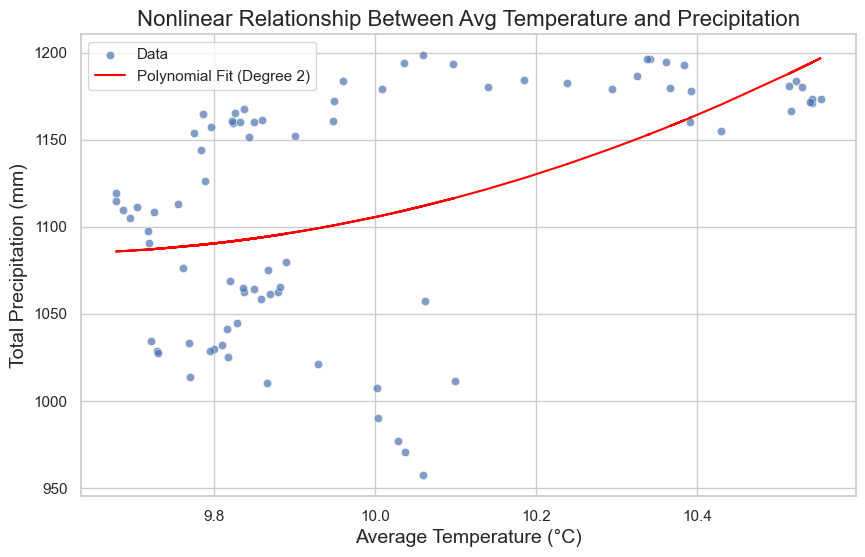

In [71]:
# Check and handle missing values
yearly_data = yearly_data.dropna(subset=['avg_temperature_v', 'precipitation_v'])

# Prepare data for polynomial regression
X = yearly_data['avg_temperature_v'].values.reshape(-1, 1)
y = yearly_data['precipitation_v'].values

# Fit a quadratic polynomial (degree=2)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression().fit(X_poly, y)

# Predict precipitation using the model
y_poly_pred = poly_model.predict(X_poly)

# Scatter plot with polynomial regression line
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=yearly_data['avg_temperature_v'], y=yearly_data['precipitation_v'], alpha=0.7, label='Data')
plt.plot(yearly_data['avg_temperature_v'], y_poly_pred, color='red', label='Polynomial Fit (Degree 2)')
plt.title('Nonlinear Relationship Between Avg Temperature and Precipitation')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Total Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Create a lagged version of precipitation
yearly_data['precipitation_lag1'] = yearly_data['precipitation_v'].shift(-1)

# Calculate correlation between lagged precipitation and temperature
lagged_corr = yearly_data['avg_temperature_v'].corr(yearly_data['precipitation_lag1'])
print(f"Lagged Correlation (Temperature vs. Precipitation Lagged by 1 Year): {lagged_corr:.2f}")

Lagged Correlation (Temperature vs. Precipitation Lagged by 1 Year): 0.46


In [69]:
# Extract month from the date index
cleaned_data['month'] = cleaned_data.index.month

# Group by month and calculate correlation
seasonal_correlation = cleaned_data.groupby('month').apply(
    lambda df: df['avg_temperature_v'].corr(df['precipitation_v'])
)
print("Seasonal Correlations (Temperature vs. Precipitation):")
print(seasonal_correlation)

Seasonal Correlations (Temperature vs. Precipitation):
month
1     0.736311
2    -0.278134
3     0.444095
4     0.436964
5     0.272818
6     0.464330
7    -0.038623
8     0.196006
9    -0.168073
10    0.329396
11    0.355505
12    0.248892
dtype: float64


/var/folders/vq/thgcfn217yd6x8lc8f1px5r80000gn/T/ipykernel_1474/2180711070.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_correlation = cleaned_data.groupby('month').apply(


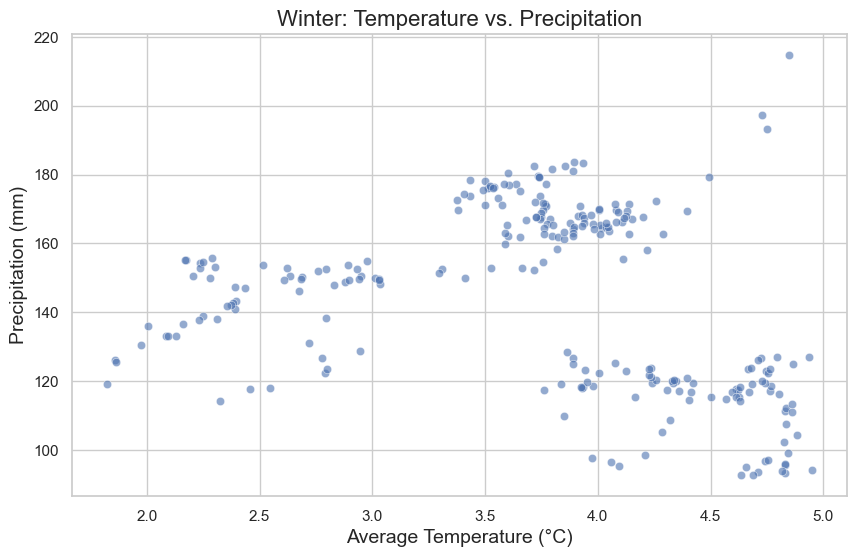

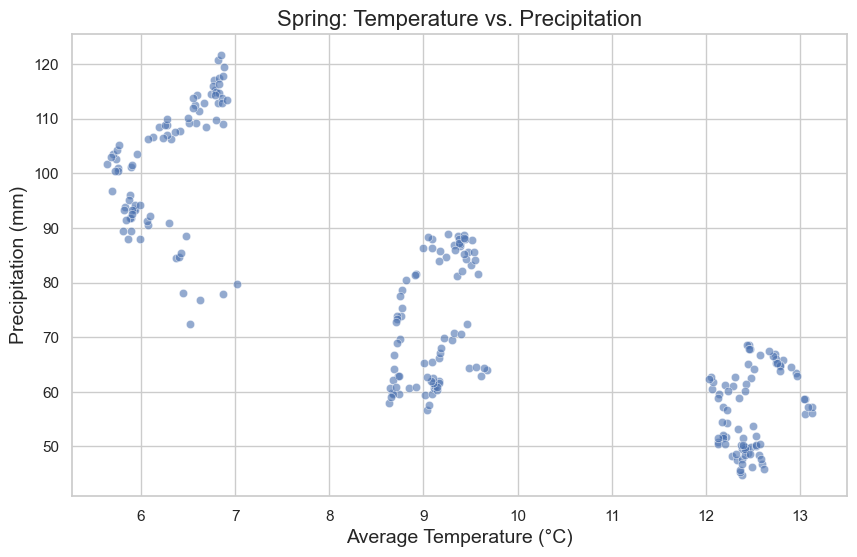

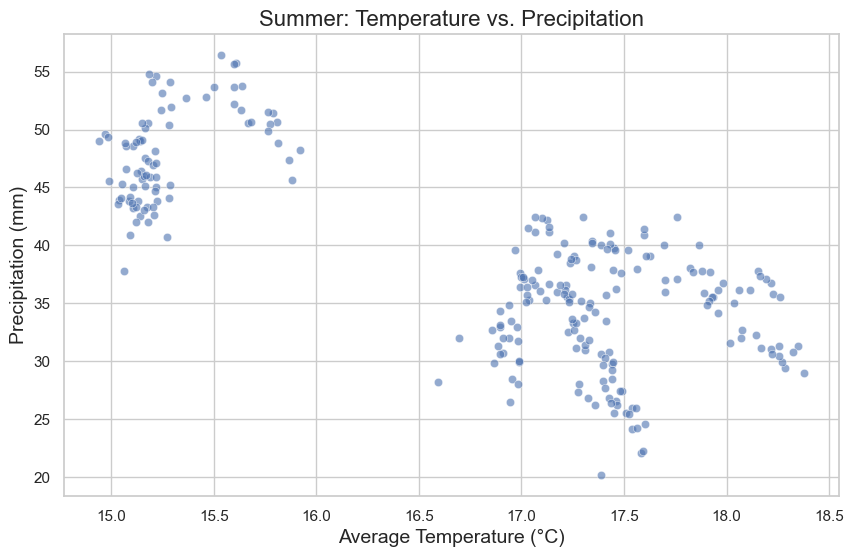

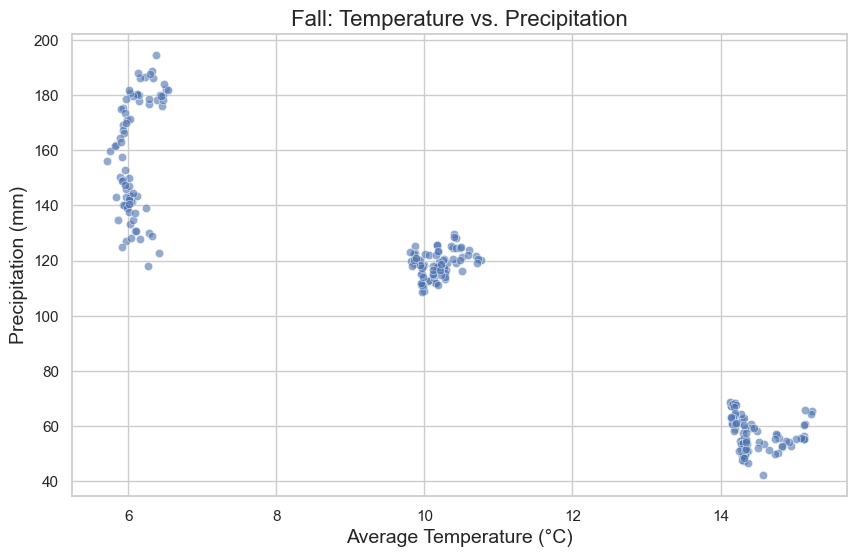

In [70]:
# Define seasons
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Generate scatter plots for each season
for season, months in seasons.items():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=cleaned_data[cleaned_data['month'].isin(months)]['avg_temperature_v'],
        y=cleaned_data[cleaned_data['month'].isin(months)]['precipitation_v'],
        alpha=0.6
    )
    plt.title(f'{season}: Temperature vs. Precipitation')
    plt.xlabel('Average Temperature (°C)')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

**Code Explanation**:
- Fit an ARIMA model to forecast average temperature values.
- Display the forecast with confidence intervals.

In [46]:
# # Set frequency to monthly and sort the index to ensure it's monotonic
# cleaned_data = cleaned_data.asfreq('MS').sort_index()

# # Now try the ARIMA model again
# from statsmodels.tsa.arima.model import ARIMA

# # ARIMA model for temperature forecasting
# temp_model = ARIMA(cleaned_data['avg_temperature_v'], order=(1, 1, 1))
# temp_fit = temp_model.fit()
# temp_forecast = temp_fit.get_forecast(steps=12)
# temp_forecast_ci = temp_forecast.conf_int()

# # Plot forecast
# plt.figure(figsize=(12, 6))
# plt.plot(cleaned_data['avg_temperature_v'], label='Observed')
# plt.plot(temp_forecast.predicted_mean, label='Forecast', color='red')
# plt.fill_between(temp_forecast_ci.index, 
#                  temp_forecast_ci.iloc[:, 0], 
#                  temp_forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
# plt.title('Average Temperature Forecast')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.legend()
# plt.show()


Prepare Data for Prophet
- Create a new DataFrame with only the date and average temperature columns.
- Rename columns to 'ds' for the date and 'y' for the temperature values, as required by Prophet.

In [57]:
# # Step 1: Prepare data for Prophet
# prophet_data = cleaned_data[['avg_temperature_v']].reset_index()
# prophet_data.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for the value

Initialize and Fit the Prophet Model
- Set up an instance of the Prophet model.
- Fit the Prophet model to the historical temperature data to capture trends and seasonality.


Generate Future Dates for Forecasting
- Create a future date range (e.g., for the next 12 months) to extend the data.
- Use Prophet to predict temperature values for these future dates.

  
Plot the Forecast
- Visualize the forecasted temperature values along with the observed data.
- Include confidence intervals to show the uncertainty range in the forecast.

In [58]:
# # Step 2: Initialize and fit the Prophet model
# prophet_model = Prophet()
# prophet_model.fit(prophet_data)

# # Step 3: Make a DataFrame for future dates and predict future values
# future = prophet_model.make_future_dataframe(periods=12, freq='M')  # Forecasting the next 12 months
# forecast = prophet_model.predict(future)

# # Step 4: Plot the forecast
# fig = prophet_model.plot(forecast)
# plt.title('Average Temperature Forecast (Prophet)')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.show()

In [59]:
# # Step 1: Limit the historical data to recent years (e.g., from 2000 onward)
# recent_data = prophet_data[prophet_data['ds'] >= '2000-01-01']

# # Step 2: Plot recent historical data and forecast
# plt.figure(figsize=(12, 6))
# plt.plot(recent_data['ds'], recent_data['y'], label='Observed', color='blue', alpha=0.6)

# # Step 3: Plot the forecasted values
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

# # Add labels and legend
# plt.title('Average Temperature Forecast (Prophet)')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.legend()
# plt.show()


In [60]:
# # Limit the historical data for plotting to the last 20 years (from 2000 onward)
# recent_data = prophet_data[prophet_data['ds'] >= '2000-01-01']  # Adjust start year as needed

# # Plot recent historical data and the forecast
# plt.figure(figsize=(12, 6))

# # Plot the observed data (last 20 years)
# plt.plot(recent_data['ds'], recent_data['y'], label='Observed', color='blue', alpha=0.6, linewidth=1)

# # Plot the forecasted values and confidence intervals
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linewidth=1)
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)

# # Customize the plot
# plt.title('Average Temperature Forecast (Prophet)')
# plt.xlabel('Year')
# plt.ylabel('Temperature (°C)')
# plt.legend()
# plt.xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2030-01-01')])  # Restrict x-axis to recent years and forecast period
# plt.show()


## Phase 2

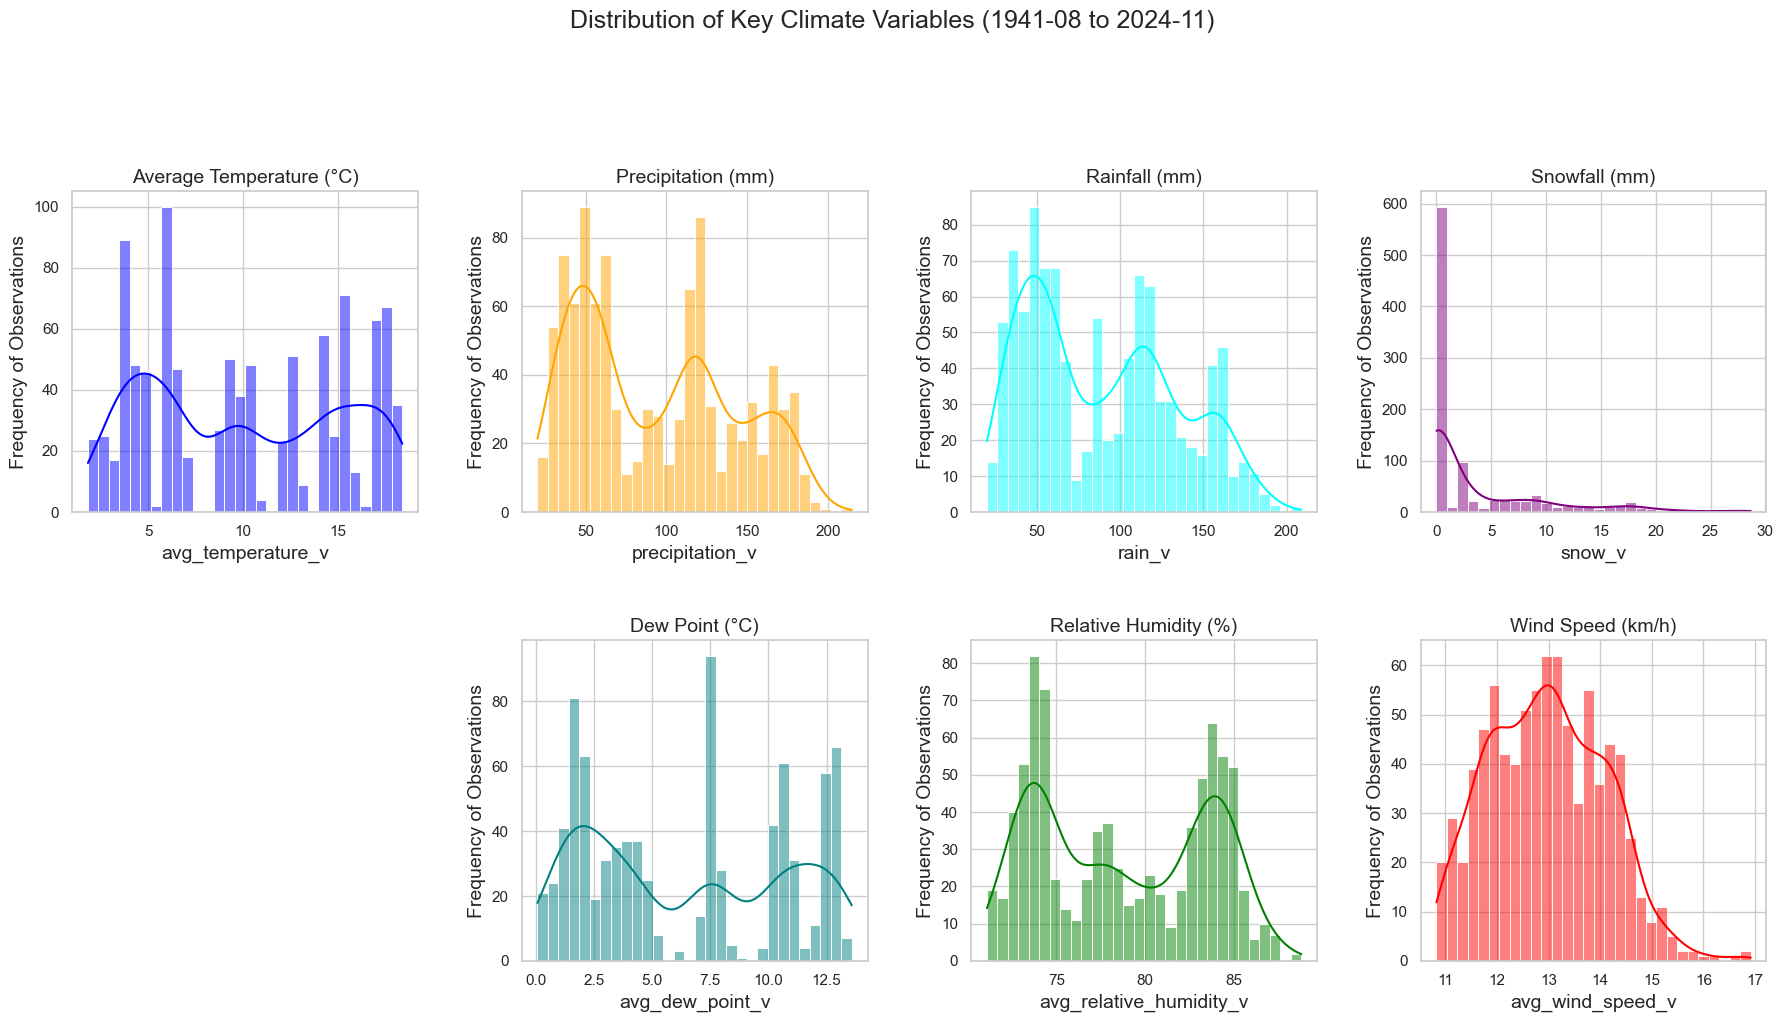

In [114]:
# Extract date range from the dataset, formatted as "YYYY-MM"
date_min = cleaned_data.index.min().strftime('%Y-%m')
date_max = cleaned_data.index.max().strftime('%Y-%m')
date_range = f" ({date_min} to {date_max})"

# Set up the figure for subplots with a 2x4 grid to give each plot more space
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle(f'Distribution of Key Climate Variables{date_range}', fontsize=18, y=1.05)

# Histogram for Average Temperature
sns.histplot(cleaned_data['avg_temperature_v'].dropna(), bins=30, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title(f"Average Temperature (°C)", fontsize=14)
axes[0, 0].set_ylabel("Frequency of Observations")

# Histogram for Precipitation
sns.histplot(cleaned_data['precipitation_v'].dropna(), bins=30, kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title(f"Precipitation (mm)", fontsize=14)
axes[0, 1].set_ylabel("Frequency of Observations")

# Histogram for Rainfall
if 'rain_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['rain_v'].dropna(), bins=30, kde=True, ax=axes[0, 2], color='cyan')
    axes[0, 2].set_title(f"Rainfall (mm)", fontsize=14)
    axes[0, 2].set_ylabel("Frequency of Observations")

# Histogram for Snowfall
if 'snow_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['snow_v'].dropna(), bins=30, kde=True, ax=axes[0, 3], color='purple')
    axes[0, 3].set_title(f"Snowfall (mm)", fontsize=14)
    axes[0, 3].set_ylabel("Frequency of Observations")

# Histogram for Solar Radiation
if 'solar_radiation_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['solar_radiation_v'].dropna(), bins=30, kde=True, ax=axes[1, 0], color='gold')
    axes[1, 0].set_title(f"Solar Radiation (MJ/m²)", fontsize=14)
    axes[1, 0].set_ylabel("Frequency of Observations")

# Histogram for Dew Point
if 'avg_dew_point_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['avg_dew_point_v'].dropna(), bins=30, kde=True, ax=axes[1, 1], color='teal')
    axes[1, 1].set_title(f"Dew Point (°C)", fontsize=14)
    axes[1, 1].set_ylabel("Frequency of Observations")

# Histogram for Relative Humidity
if 'avg_relative_humidity_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['avg_relative_humidity_v'].dropna(), bins=30, kde=True, ax=axes[1, 2], color='green')
    axes[1, 2].set_title(f"Relative Humidity (%)", fontsize=14)
    axes[1, 2].set_ylabel("Frequency of Observations")

# Histogram for Wind Speed
if 'avg_wind_speed_v' in cleaned_data.columns:
    sns.histplot(cleaned_data['avg_wind_speed_v'].dropna(), bins=30, kde=True, ax=axes[1, 3], color='red')
    axes[1, 3].set_title(f"Wind Speed (km/h)", fontsize=14)
    axes[1, 3].set_ylabel("Frequency of Observations")

# Hide any empty subplots (if fewer than 8 variables)
for i in range(2):
    for j in range(4):
        if not axes[i][j].has_data():
            axes[i][j].set_visible(False)

# Adjust layout to improve spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust rect to fit the overall title
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Add spacing between plots
plt.show()


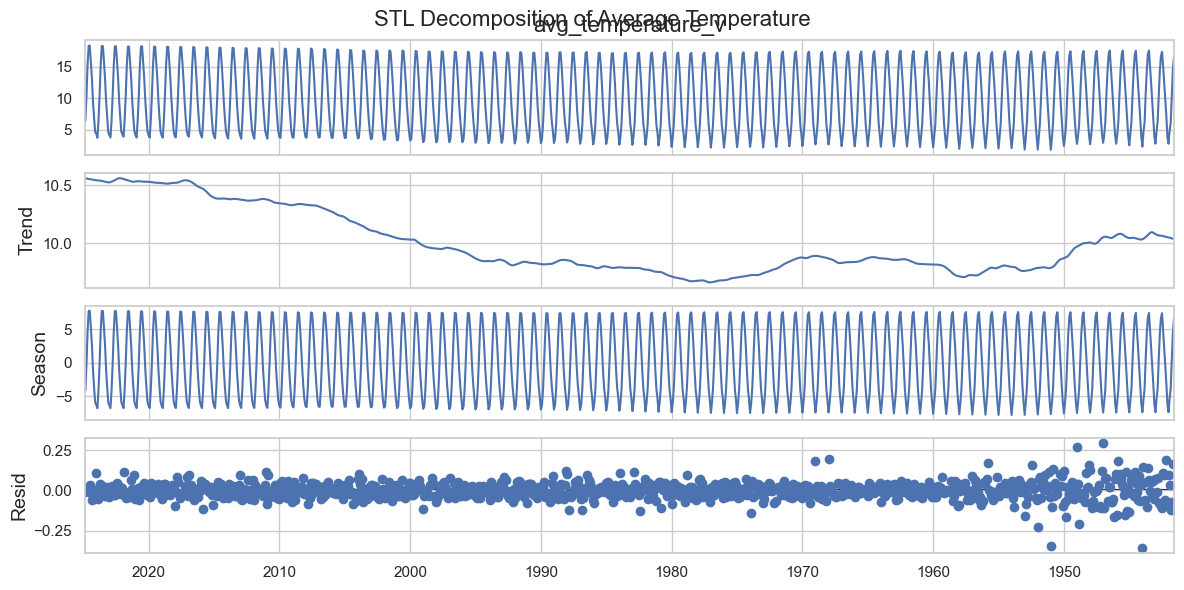

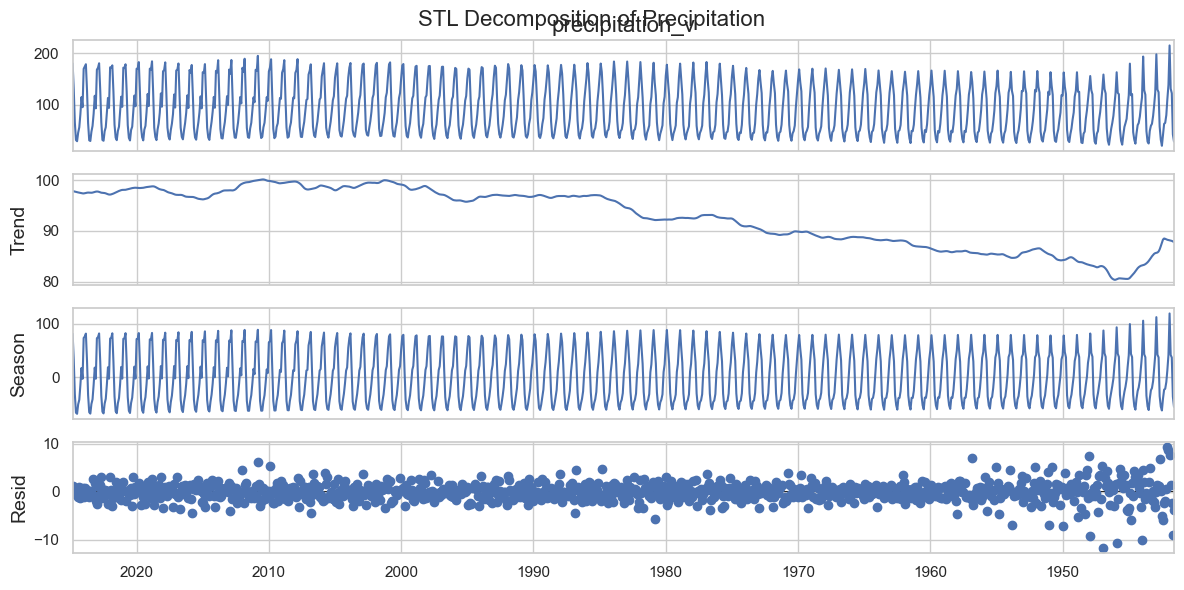

In [112]:
from statsmodels.tsa.seasonal import STL

# Decompose average temperature with STL
stl_temp = STL(cleaned_data['avg_temperature_v'], seasonal=13).fit()
stl_temp.plot()
plt.suptitle("STL Decomposition of Average Temperature", fontsize=16)
plt.show()

# Decompose precipitation with STL
stl_precip = STL(cleaned_data['precipitation_v'], seasonal=13).fit()
stl_precip.plot()
plt.suptitle("STL Decomposition of Precipitation", fontsize=16)
plt.show()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2024-11-01 to 1941-08-01
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   max_dew_point_v          851 non-null    float64
 1   max_dew_point_s          851 non-null    float64
 2   max_dew_point_c          851 non-null    float64
 3   max_dew_point_d          851 non-null    object 
 4   max_relative_humidity_v  851 non-null    float64
 5   max_relative_humidity_s  851 non-null    float64
 6   max_relative_humidity_c  851 non-null    float64
 7   max_relative_humidity_d  851 non-null    object 
 8   max_temperature_v        1000 non-null   float64
 9   max_temperature_s        1000 non-null   float64
 10  max_temperature_c        1000 non-null   int64  
 11  max_temperature_d        1000 non-null   object 
 12  max_wind_speed_v         851 non-null    float64
 13  max_wind_speed_s         851 non-null    float64
 14  max_wi

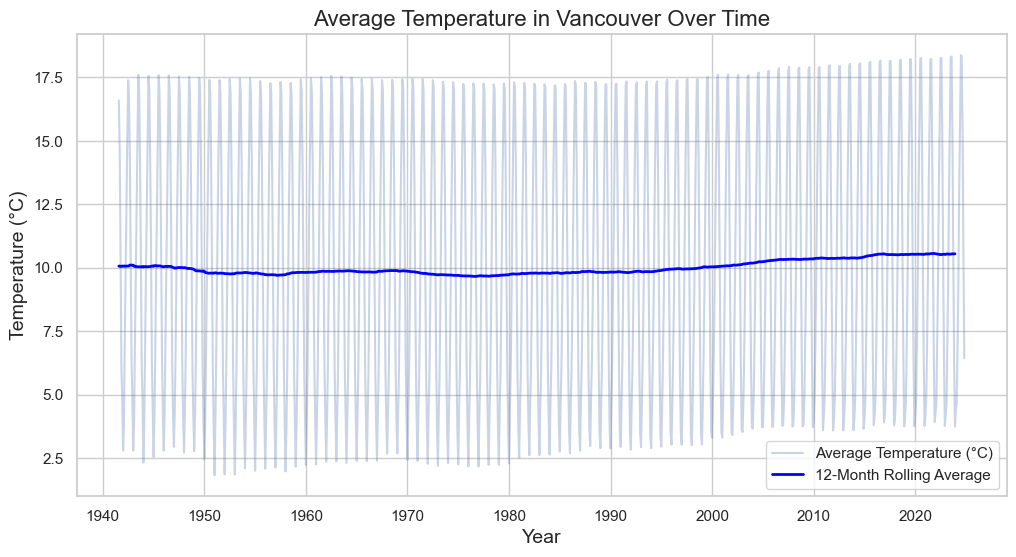

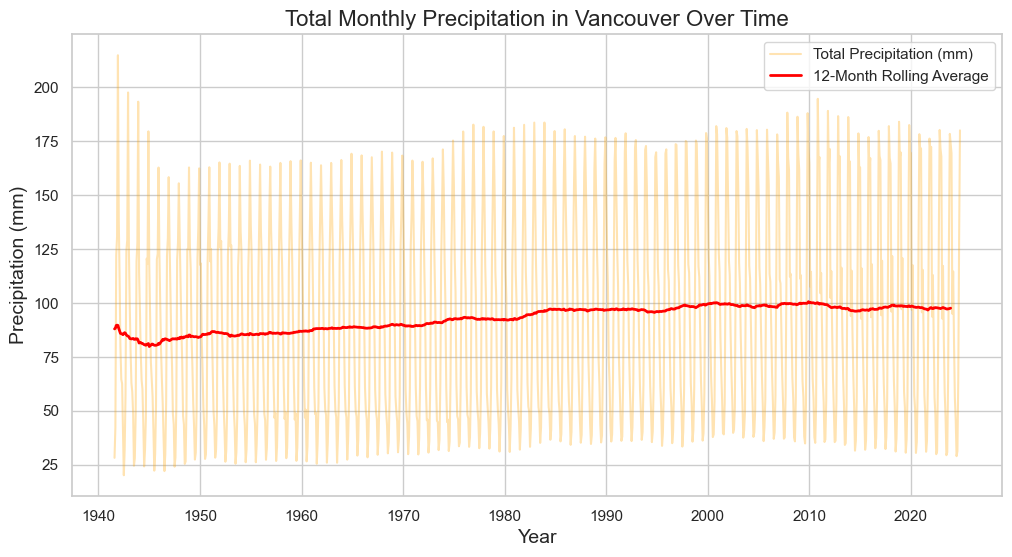